In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random

np.random.seed()
sequence_length = 100
random_data_dup = 10
epochs = 1
batch_size = 50

Using TensorFlow backend.


In [2]:
def dropin(X, y):
#      http://simaaron.github.io/Estimating-rainfall-from-weather-radar-readings-using-recurrent-neural-networks/
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    X_hat = []
    y_hat = []
    for i in range(0, len(X)):
        for j in range(0, np.random.random_integers(0, random_data_dup)):
            X_hat.append(X[i, :])
            y_hat.append(y[i])
    return np.asarray(X_hat), np.asarray(y_hat)

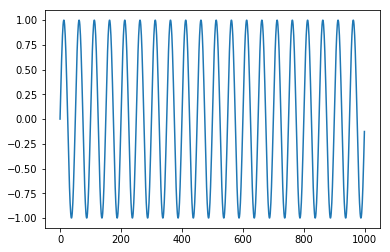

In [3]:
def gen_wave_normal():
    t = np.arange(0.0, 10.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    return wave1

a = gen_wave_normal()
plt.plot(a)
plt.show()

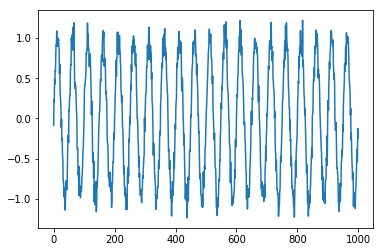

In [4]:
def gen_wave_noise():
    t = np.arange(0.0, 10.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.1, len(t))
    wave1 = wave1 + noise
    return wave1


a = gen_wave_noise()
plt.plot(a)
plt.show()

wave1 1000
wave2 1000


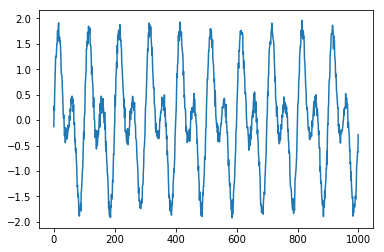

In [5]:
def gen_wave_2():
    t = np.arange(0.0, 10.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.1, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    return wave1 + wave2


a = gen_wave_2()
plt.plot(a)
plt.show()

wave1 1000
wave2 1000
wave3 50


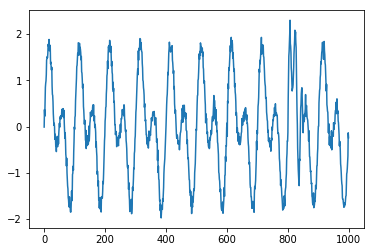

In [6]:
def gen_wave():
    #Generate a synthetic wave by adding up a few sine waves and some noise and return the final wave
    t = np.arange(0.0, 10.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.1, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = round(0.8 * len(t))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    return wave1 + wave2


a = gen_wave()
plt.plot(a)
plt.show()

In [7]:
def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

wave1 1000
wave2 1000
wave3 50
Length of Data 1000
Creating train data...
Mean of train data :  0.0009038643601104305
Train data shape  :  (600, 100)
X shape: (600, 99)
y shape: (600,)
Creating test data...
Mean of test data :  0.017179912927927542
Test data shape  :  (300, 100)
Shape X_train (2965, 99)
Shape X_test (300, 99)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  


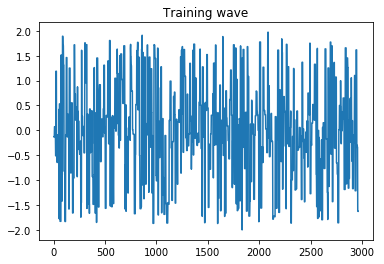

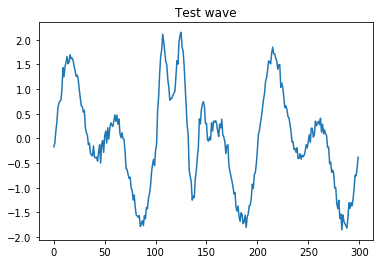

In [8]:
def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))
    print("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_train, y_train = dropin(X_train, y_train)

    train_main = y_train
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    test_main = y_test
    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_train, y_train, X_test, y_test, train_main,test_main

X_train, y_train, X_test, y_test, train_main, test_main = get_split_prep_data(0, 700, 600, 1000)
plt.title("Training wave")
plt.plot(y_train)
plt.show()
plt.title("Test wave")
plt.plot(y_test)
plt.show()

In [9]:
def build_model():
    model = Sequential()
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(256,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100,return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.add(Activation("linear"))

    model.compile(loss="mse", optimizer="rmsprop")
    return model

In [10]:
def run_network(model=None, data=None):

    if data is None:
        print ('Loading data... ')
        X_train, y_train, X_test, y_test, train_main, test_main = get_split_prep_data(0, 700, 600, 1000)
    else:
        X_train, y_train, X_test, y_test, train_main, test_main = data

    print ('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        return model, y_test, 0
    return model, y_test, predicted,X_train, y_train, X_test, train_main, test_main

model, y_test, predicted,X_train, y_train, X_test, train_main, test_main = run_network()

Loading data... 
wave1 1000
wave2 1000
wave3 50
Length of Data 1000
Creating train data...
Mean of train data :  -0.0023158612484182085
Train data shape  :  (600, 100)
X shape: (600, 99)
y shape: (600,)
Creating test data...
Mean of test data :  0.02788728872938192
Test data shape  :  (300, 100)
Shape X_train (2939, 99)
Shape X_test (300, 99)

Data Loaded. Compiling...

Instructions for updating:
Colocations handled automatically by placer.
Training...


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2792 samples, validate on 147 samples
Epoch 1/1
2792/2792 [==============================] - 17s 6ms/step - loss: 0.1782 - val_loss: 0.0220
Predicting...
Reshaping predicted


<Figure size 2880x1440 with 0 Axes>

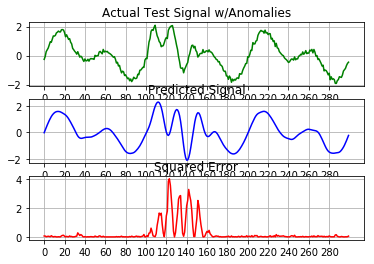

In [11]:
    try:
        plt.figure(figsize=(40,20))
        plt.figure()
        plt.subplot(311)
        plt.xticks(np.arange(0,300, 20.0))
        plt.grid()
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'g')
        plt.subplot(312)
        plt.xticks(np.arange(0,300, 20.0))
        plt.grid()
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'b')
        plt.subplot(313)
        plt.title("Squared Error")
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        plt.xticks(np.arange(0,300, 20.0))
        plt.grid()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print (str(e))
